# Read in & analyse the CIMMYT disease score data

Run in 24hr_env as the analysis is similar

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Read in the data

Only collected once for each year 28/06/2023 & 17/06/2024

In [2]:
disease_24 = pd.read_excel('/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/metadata/CIMMYT_Scoresheet_24.xlsx',
                            skiprows=8)

#Drop unnecessary cols
disease_24 = disease_24.drop(columns=['Selection History', 'Origin', 'Rep', 'Sub Block',
       'Entry', 'Heading', 'Height', 'Lodging',])

# Change NaN to 0 in all columns except 'Selection History' and 'Plot'
cols_to_fill = disease_24.columns.difference(['Selection History', 'Plot'])
disease_24[cols_to_fill] = disease_24[cols_to_fill].fillna(0)

#Rename Cross Name to Cross
disease_24 = disease_24.rename(columns={'Cross Name': 'Cross'})

In [3]:
disease_23 = pd.read_excel('/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/metadata/CIMMYT_Scoresheet_23.xlsx',
                           skiprows=1)

#Drop uneccesarry col
disease_23 = disease_23.drop(columns=['Entry', 'Notes', 'Ear Emergence'])

# Change - / Na to 0 in all columns except 'Ear Emergence'
cols_to_fill = disease_23.columns.difference(['Ear Emergence'])
disease_23[cols_to_fill] = disease_23[cols_to_fill].replace('-', 0).fillna(0)

#Rename the disease cols
disease_23 = disease_23.rename(columns={'MIL': 'Mildew',
                                        'YR ': 'Yellow Rust',
                                        'BR': 'Brown Rust',
                                        'St': 'Septoria'})

/Users/berelsom/opt/anaconda3/envs/maize_environment/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_5523/3232530015.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  disease_23[cols_to_fill] = disease_23[cols_to_fill].replace('-', 0).fillna(0)


Only 6 crosses are found in both dataframes, so can't necessarily comapre at cross level. Instead want to plot averages of the different diseases in both years

In [4]:
#Identify which crosses are present in both dfs, and which are just in one
crosses_23 = set(disease_23['Cross'])
crosses_24 = set(disease_24['Cross'])

crosses_in_both = crosses_23.intersection(crosses_24)
# crosses_in_23 = crosses_23.difference(crosses_24)
# crosses_in_24 = crosses_24.difference(crosses_23)

print(f'Crosses in both: {len(crosses_in_both)}')
# print(f'Crosses in 23 only: {len(crosses_in_23)}')
# print(f'Crosses in 24 only: {len(crosses_in_24)}')

Crosses in both: 6


Get some range data

In [18]:
#To get the data
disease_cols = ['Mildew', 'Yellow Rust', 'Brown Rust', 'Septoria']
# For 2023
stats_23 = disease_23[disease_cols].agg(['min', 'max', 'median', 'mean', 'std', 'quantile'])
stats_23 = stats_23.round(2)
stats_23

,Mildew,Yellow Rust,Brown Rust,Septoria
min,0.00,0.00,0.00,0.00
max,0.10,75.00,0.01,15.00
median,0.00,17.00,0.00,0.00
mean,0.00,24.67,0.00,1.43
std,0.01,22.58,0.00,3.14
quantile,0.00,17.00,0.00,0.00


In [19]:
# For 2024
stats_24 = disease_24[disease_cols].agg(['min', 'max', 'median', 'mean', 'std', 'quantile'])
stats_24 = stats_24.round(2)
stats_24

,Mildew,Yellow Rust,Brown Rust,Septoria
min,0.0,0.00,0.00,0.00
max,0.0,75.00,10.00,65.00
median,0.0,10.00,0.00,12.00
mean,0.0,13.97,0.18,14.35
std,0.0,16.63,1.15,13.87
quantile,0.0,10.00,0.00,12.00


## Plot the disease data

- Calculate average, and SD for each disease in 2023 & 2024
- Plot bar graph showing all diseases for each year (colour by year)

In [5]:
#To get the data
disease_cols = ['Mildew', 'Yellow Rust', 'Brown Rust', 'Septoria']

# Calculate mean and standard deviation for each year
mean_sd_23 = disease_23[disease_cols].agg(['mean', 'std']).T
mean_sd_24 = disease_24[disease_cols].agg(['mean', 'std']).T

# Combine the dataframes and reshape to long format
mean_sd = pd.concat([mean_sd_23, mean_sd_24], axis=1, keys=['2023', '2024'])
mean_sd.columns = ['Mean_23', 'SD_23', 'Mean_24', 'SD_24']

mean_sd

,Mean_23,SD_23,Mean_24,SD_24
Mildew,0.002500,0.014513,0.000,0.000000
Yellow Rust,24.668750,22.584001,13.972,16.625811
Brown Rust,0.000208,0.001443,0.180,1.149264
Septoria,1.427083,3.140317,14.350,13.867610


To get error bars need to plot it like this

In [6]:
# Melt dfs
melt_23 = disease_23.melt(id_vars=["Plot", "Cross"], 
                     var_name="Disease", 
                     value_name="Score")

melt_24 = disease_24.melt(id_vars=["Plot", "Cross"],
                     var_name="Disease",
                     value_name="Score")
# add column for year
melt_23['Year'] = 2023
melt_24['Year'] = 2024

# Combine the dfs
all_disease = pd.concat([melt_23, melt_24])

Looking at why the SD is quite large for 2024 Brown Rust - appears to be one Cross which was socre a 10

In [135]:
all_disease[(all_disease['Disease'] == 'Mildew') & 
            # (all_disease['Year'] == 2024) & 
            (all_disease['Score'] > 0)]

,Plot,Cross,Disease,Score,Year
17,18,REEDLING-GL5A_2/QUAIU,Mildew,0.01,2023
12,13,REEDLING-GL5A_2/QUAIU,Mildew,0.01,2023
38,39,SOKOLL/WBLL1/5/CROC_1/AE.SQUARROSA (205)//BORL...,Mildew,0.10,2023


<Figure size 1000x600 with 0 Axes>

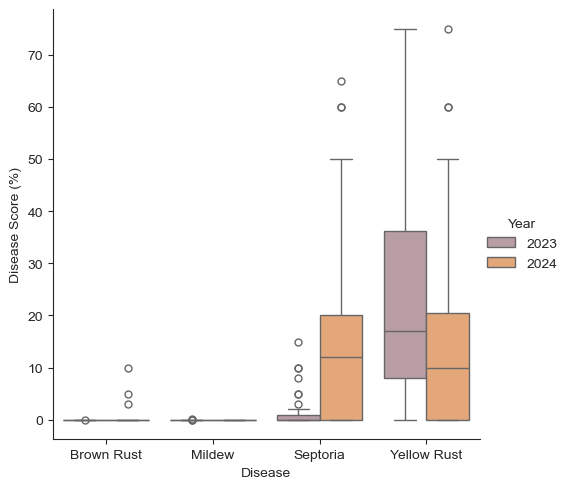

In [17]:
sns.set_style("ticks")

# Set the width and height of the figure
plt.figure(figsize=(10,6))

# Convert the 'Year' column to string type
all_disease['Year'] = all_disease['Year'].astype(str)
all_disease = all_disease.sort_values('Disease')

# custom color palette for years
year_palette = {'2023': '#BD98A2', '2024': '#F5A469'}
all_disease['Year'] = pd.Categorical(all_disease['Year'], categories=['2023', '2024'], ordered=True)
# Plot the data
sns.catplot(data=all_disease, 
            x='Disease', 
            y='Score', 
            hue='Year', 
            kind='box', #can change this to e.g. bar
            palette=year_palette)


#Add Y label 
plt.ylabel('Disease Score (%)')

# Save the plot
plt.savefig('/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/Graphs/disease_scores.pdf',
             dpi=300, bbox_inches='tight')